# Libraries

In [1]:
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(tidyr))
suppressPackageStartupMessages(library(ggplot2))
suppressPackageStartupMessages(library(forecast))
suppressPackageStartupMessages(library(lmtest))
suppressPackageStartupMessages(library(strucchange))
suppressPackageStartupMessages(library(reshape))
suppressPackageStartupMessages(library(tseries))
suppressPackageStartupMessages(library(lubridate))
suppressPackageStartupMessages(library(FitAR))
suppressPackageStartupMessages(library(propagate))
# The last package is used for uncertainty propagation.
# It allows for quick 2nd degree Taylor approximation 
# or Monte-Carlo evaluation

----

# Pre-preparation

In [2]:
# Read from a pre-cleaned file. 
Lombardia_tot <- read.csv("Lombardia.csv", colClasses = c('Date', 'integer', 
                                                      'character', 'integer')) %>% 
            dplyr::group_by(DATA) %>% 
            dplyr::summarise(DECESSI = sum(DECESSI))
# 
# This cleaning is meant to speed up things, and allow
# to have day-deaths 

In [3]:
# Define two variable for plotting purposes
Lombardia_tot["Month.Day"] = as.Date(format(Lombardia_tot$DATA, format="%m-%d"), 
                                 format="%m-%d")
Lombardia_tot["Year"] =format(Lombardia_tot$DATA, format="%Y")

Warning message:
“Removed 1 row(s) containing missing values (geom_path).”


pdf 
  2

Warning message:
“Removed 1 row(s) containing missing values (geom_path).”


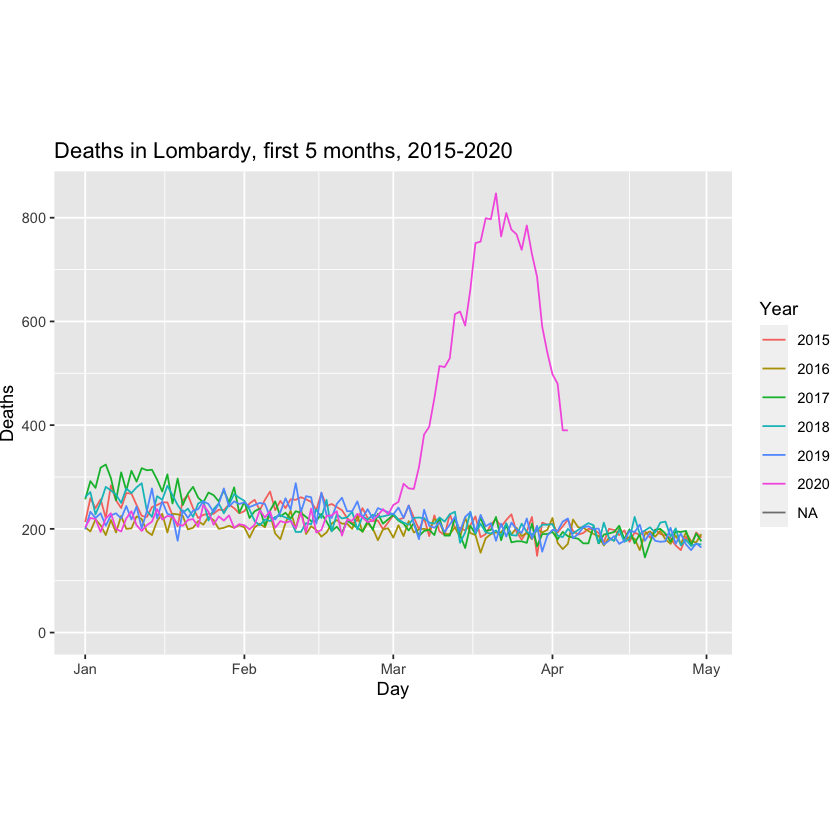

In [4]:
# Plot and save to pdf the deaths for all data 
pdf("images/lombardy_deaths_2015_2020.pdf")
ggplot(data=Lombardia_tot, aes(x=Month.Day, y=DECESSI, color=Year)) + 
geom_line() + theme(plot.margin = margin(3,0,3,0, "cm")) + 
labs(title="Deaths in Lombardy, first 5 months, 2015-2020", 
     y='Deaths', x='Day')
dev.off()
ggplot(data=Lombardia_tot, aes(x=Month.Day, y=DECESSI, color=Year)) + 
geom_line() + theme(plot.margin = margin(3,0,3,0, "cm")) + 
labs(title="Deaths in Lombardy, first 5 months, 2015-2020", 
     y='Deaths', x='Day')

# Preparation

In [5]:
# Read from a pre-cleaned file. 
Lombardia <- read.csv("Lombardia.csv", colClasses = c('Date', 'integer', 
                                                      'character', 'integer')) %>% 
            dplyr::filter(DATA < "2020-01-01") %>%
            dplyr::group_by(DATA) %>% 
            dplyr::summarise(DECESSI = sum(DECESSI))
# 
# This cleaning is meant to speed up things, and allow
# to have day-deaths 

In [6]:
# Define two variable for plotting purposes
Lombardia["Month.Day"] = as.Date(format(Lombardia$DATA, format="%m-%d"), 
                                 format="%m-%d")
Lombardia["Year"] =format(Lombardia$DATA, format="%Y")

In [15]:
# Plot and save to pdf the deaths for 2015-2019
pdf("images/lombardy_deaths_2015_2019.pdf")
ggplot(data=Lombardia, aes(x=Month.Day, y=DECESSI, color=Year)) + 
geom_line() + theme(plot.margin = margin(3,0,3,0, "cm")) + 
labs(title="Deaths in Lombardy, first 5 months, 2015-2019", 
     y='Deaths', x='Day')
dev.off()

pdf 
  2

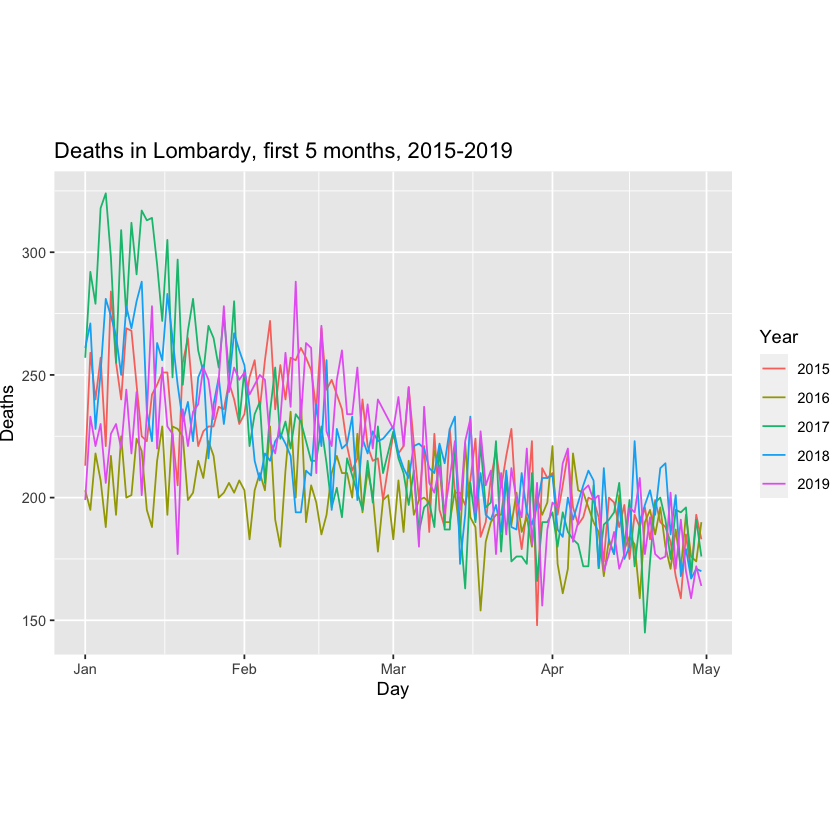

In [16]:
ggplot(data=Lombardia, aes(x=Month.Day, y=DECESSI, color=Year)) + 
geom_line() + theme(plot.margin = margin(3,0,3,0, "cm")) + 
labs(title="Deaths in Lombardy, first 5 months, 2015-2019", y='Deaths', x='Day')

# Forecasting

In [17]:
# We create a time series with only the deaths.
# We do not take into account the date, and out
# each year next to the other
tsLomb = ts(Lombardia$DECESSI)

Series: tsLomb 
ARIMA(3,0,0) with non-zero mean 

Coefficients:
         ar1     ar2     ar3      mean
      0.3332  0.3442  0.2014  213.9046
s.e.  0.0400  0.0399  0.0401    6.1267

sigma^2 estimated as 347.6:  log likelihood=-2609.66
AIC=5229.33   AICc=5229.43   BIC=5251.32

Training set error measures:
                     ME     RMSE      MAE        MPE     MAPE      MASE
Training set -0.0502256 18.58174 14.41351 -0.7676315 6.785628 0.8114955
                     ACF1
Training set -0.008739115


pdf 
  2

pdf 
  2

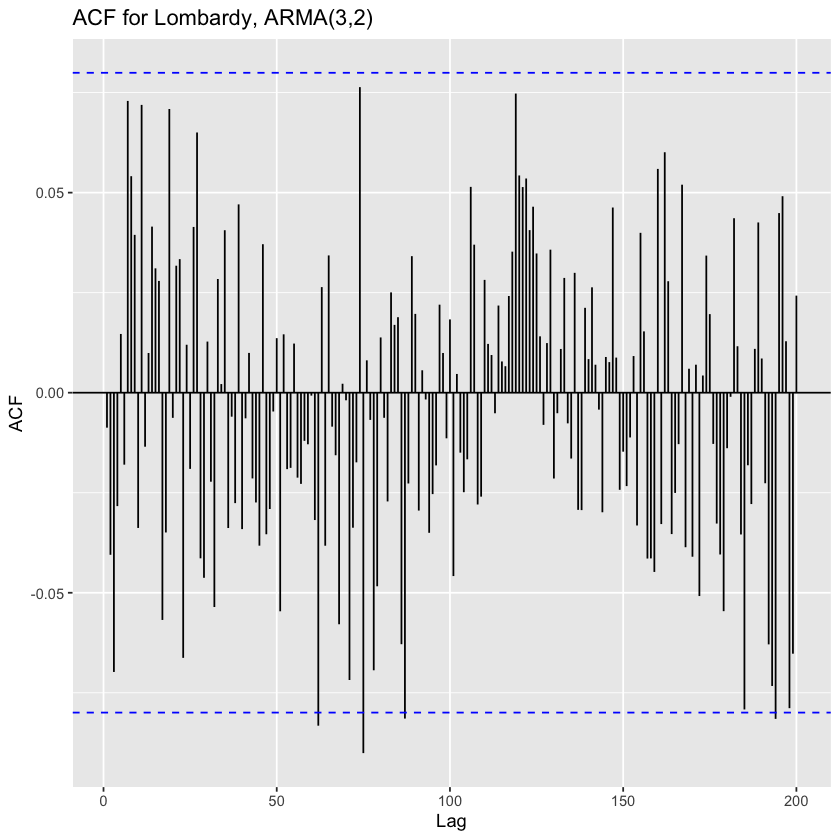


	Ljung-Box test

data:  Residuals from ARIMA(3,0,0) with non-zero mean
Q* = 11.493, df = 6, p-value = 0.07429

Model df: 4.   Total lags used: 10



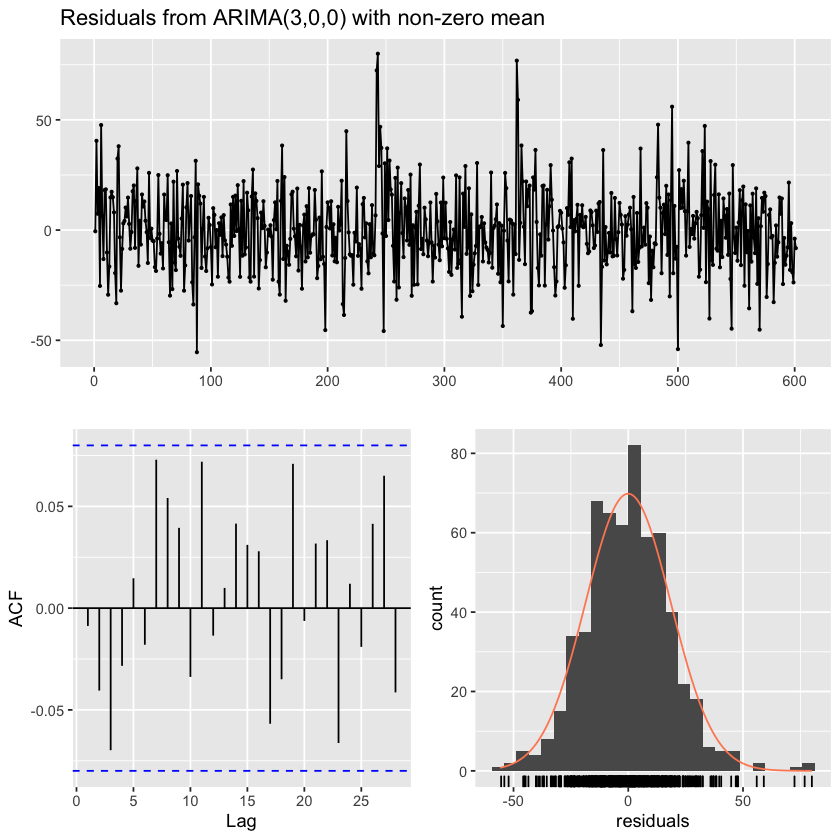

In [18]:
# First models used
# This one was not deployed for the final analysis.
modLomb_prime = Arima(tsLomb, order=c(3,0,0))
summary(modLomb_prime)
pdf("images/ACF_prime.pdf")
ggAcf(modLomb_prime$residuals, lag.max = 200) + labs(title="ACF for Lombardy, AR(3))")
dev.off()
# We can notice a small problem around lag 120, 
# but we can infer it's in the 5% error.
# We strenthen that our model is not seasonal
ggAcf(modLomb_prime$residuals, lag.max = 200) + labs(title="ACF for Lombardy, ARMA(3,2)")

pdf("images/check_residuals_prime.pdf")
checkresiduals(modLomb_prime, test=FALSE)
dev.off()
checkresiduals(modLomb_prime)
# Normality test is passed, thus our model 
# is decent

In [19]:
# This model is the best one we found
# through trial and error
modLomb = Arima(tsLomb, order=c(3,0,2))
summary(modLomb)

Series: tsLomb 
ARIMA(3,0,2) with non-zero mean 

Coefficients:
          ar1     ar2     ar3     ma1      ma2      mean
      -0.1603  0.8830  0.1754  0.4726  -0.4511  213.6723
s.e.   0.0892  0.0574  0.0707  0.0861   0.0827    7.3043

sigma^2 estimated as 343.4:  log likelihood=-2605.1
AIC=5224.2   AICc=5224.39   BIC=5254.99

Training set error measures:
                      ME     RMSE      MAE        MPE     MAPE      MASE
Training set -0.08107139 18.43942 14.27941 -0.7704594 6.719401 0.8039451
                    ACF1
Training set 0.007128221


In [20]:
coeftest(modLomb)
# All of the coeffients are significant


z test of coefficients:

            Estimate Std. Error z value  Pr(>|z|)    
ar1        -0.160349   0.089174 -1.7982   0.07215 .  
ar2         0.883045   0.057390 15.3868 < 2.2e-16 ***
ar3         0.175418   0.070673  2.4821   0.01306 *  
ma1         0.472619   0.086099  5.4892 4.037e-08 ***
ma2        -0.451080   0.082689 -5.4552 4.893e-08 ***
intercept 213.672265   7.304333 29.2528 < 2.2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


pdf 
  2

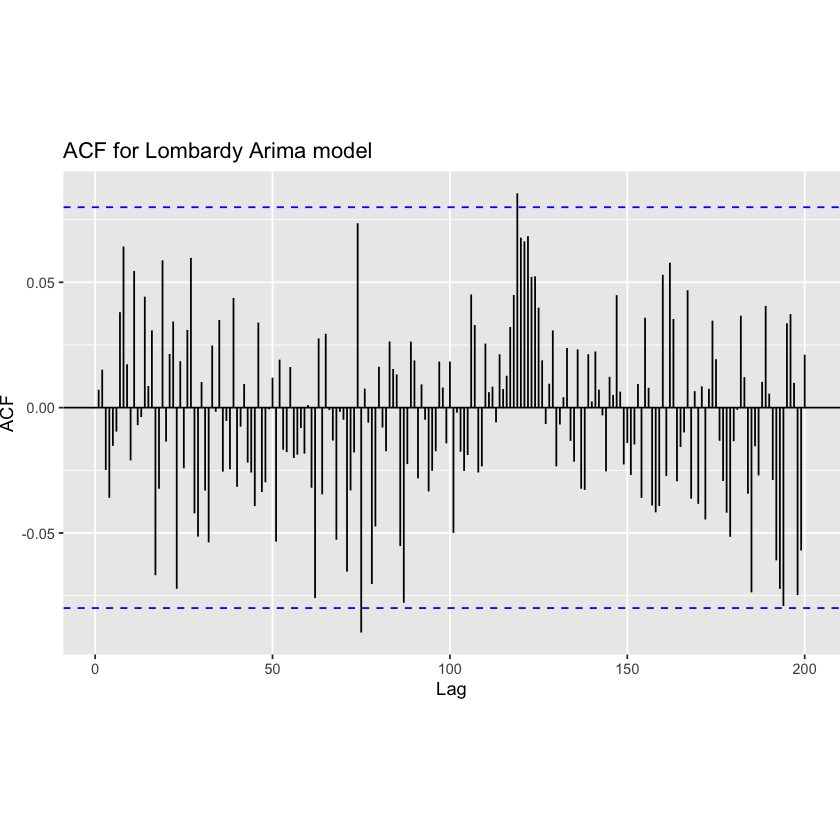

In [21]:
pdf("images/ACF.pdf")
ggAcf(modLomb$residuals, lag.max = 200) + labs(title="ACF for Lombardy Arima model") +
theme(plot.margin = margin(3,0,3,0, "cm")) 
dev.off()
# We can notice a small problem around lag 120, 
# but we can infer it's in the 5% error.
# We strenthen that our model is not seasonal
ggAcf(modLomb$residuals, lag.max = 200) + labs(title="ACF for Lombardy Arima model")+
theme(plot.margin = margin(3,0,3,0, "cm"))  

pdf 
  2


	Ljung-Box test

data:  Residuals from ARIMA(3,0,2) with non-zero mean
Q* = 5.3922, df = 4, p-value = 0.2494

Model df: 6.   Total lags used: 10



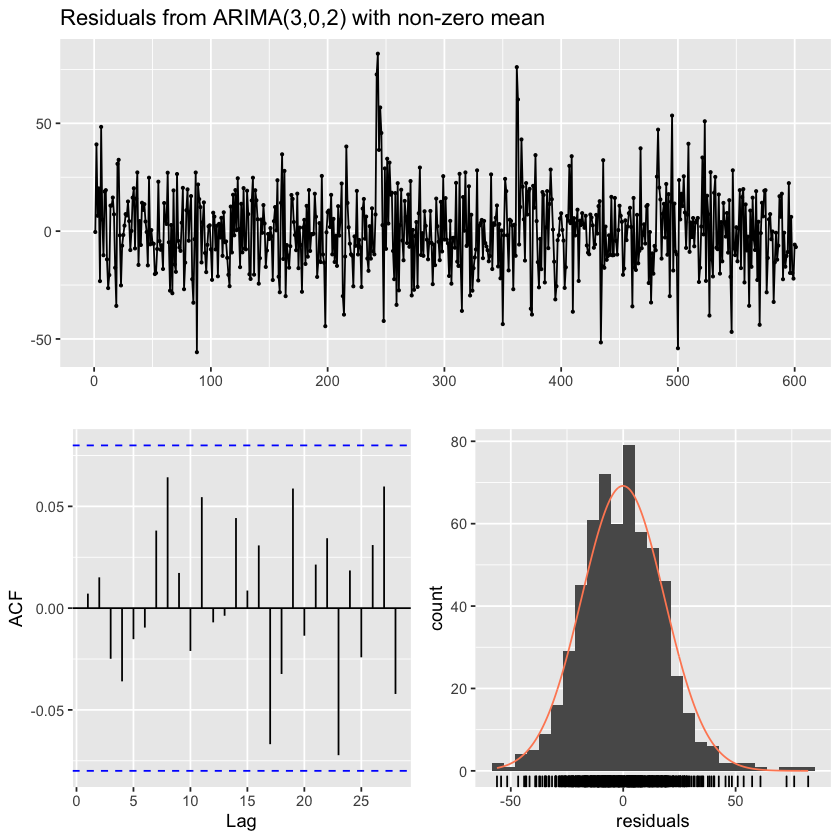

In [22]:
pdf("images/check_residuals.pdf")
checkresiduals(modLomb, test=FALSE)
dev.off()
checkresiduals(modLomb)
# Normality test is passed, thus our model 
# is decent

In [23]:
LjungBoxTest(residuals(modLomb), k = 1, lag.max = 20)

,m,Qm,pvalue
,1,0.03,0.8609328
,2,0.17,0.6808862
,3,0.54,0.7618309
,4,1.33,0.7220687
,5,1.47,0.8317214
,6,1.53,0.9099505
,7,2.41,0.8781670
,8,4.94,0.6675585
,9,5.12,0.7445977
,10,5.39,0.7988690


In [24]:
#Normality test
jarque.bera.test(residuals(modLomb))
# According to this test it is not normal
# But, looking at the graph above, we can infer that 
# it is most likely due to a few outliers


	Jarque Bera Test

data:  residuals(modLomb)
X-squared = 64.621, df = 2, p-value = 9.326e-15


pdf 
  2

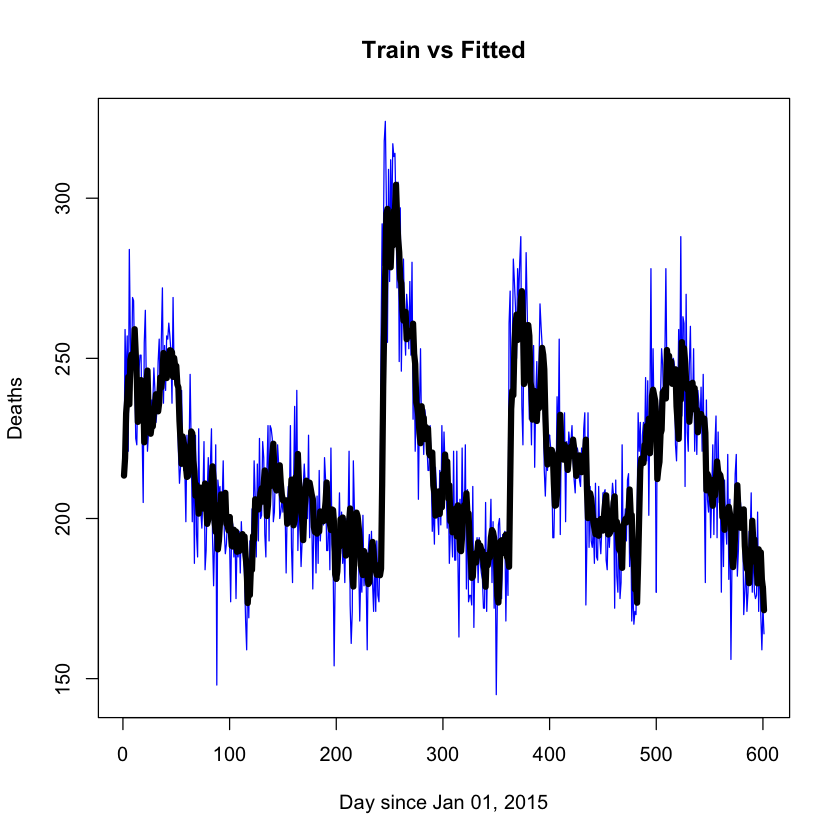

In [26]:
pdf("images/fit.pdf")
plot(tsLomb, col='blue', lty=1, main="Train vs Fitted", ylab="Deaths", xlab="Day since Jan 01, 2015")
lines(modLomb$fitted, lwd=5)
dev.off()
plot(tsLomb, col='blue', lty=1, main="Train vs Fitted", ylab="Deaths", xlab="Day since Jan 01, 2015")
lines(modLomb$fitted, lwd=5)
# The fitting of the model is very accurate

pdf 
  2

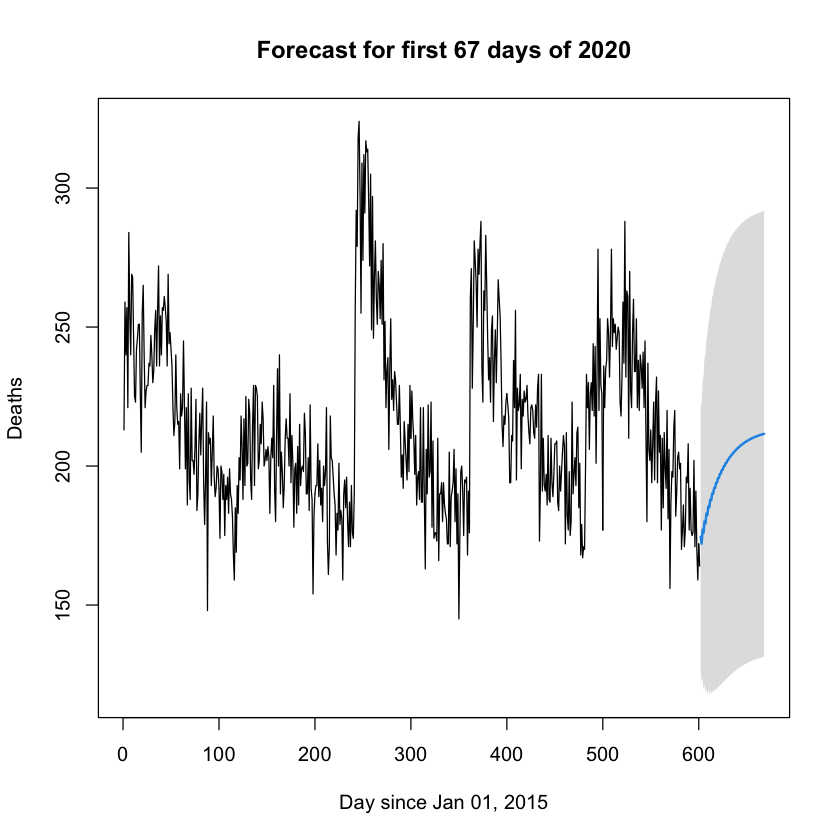

In [28]:
N = 67
futForecast = forecast(modLomb,h=N, level=c(99))
pdf("images/forecast.pdf")
plot(futForecast, type='l', main=paste("Forecast for first", N, "days of 2020"),
    xlab='Day since Jan 01, 2015', ylab='Deaths') 
dev.off()
plot(futForecast, type='l', main=paste("Forecast for first", N, "days of 2020"),
    xlab='Day since Jan 01, 2015', ylab='Deaths') 

# Estimate

We will use this forecast to subtract to the 2020 real deaths in Lombardy. In doing this, we eliminate the "standard" number of deaths from our analysis: we expect only those days where a large number of covid-related deaths occurded to be significant.

In [29]:
# Load the data again but consider only for 2020
Lombardia2020 <- read.csv("Lombardia.csv", colClasses = c('Date', 'integer', 
                                                          'character', 'integer')) %>% 
            dplyr::filter(DATA > "2020-01-01" & DATA < "2020-03-27") %>%
            dplyr::group_by(DATA) %>% 
            dplyr::summarise(DECESSI = sum(DECESSI))
# I know, loading twice the same dataset is bad pratice,
# but it's fast so there is no big downside

In [30]:
# Subtract forecast value to real numbers
# We select a 90% confidence interval
futurVal <- forecast(modLomb,h=length(Lombardia2020$DECESSI), level=c(99))
futDf = data.frame(futurVal)

In [31]:
Lombardia2020 = cbind(Lombardia2020,futDf)

In [32]:
Lombardia2020["COVID_DEC"] = Lombardia2020$DECESSI - Lombardia2020$Point.Forecast
Lombardia2020["COVID_DEC_HI"] = Lombardia2020$DECESSI - Lombardia2020$Lo.99
Lombardia2020["COVID_DEC_LO"] = Lombardia2020$DECESSI - Lombardia2020$Hi.99

In [33]:
pdf("images/lombardy_clean.pdf")
ggplot(Lombardia2020, aes(DATA, COVID_DEC, ymin = COVID_DEC_LO, ymax = COVID_DEC_HI)) +
geom_line() + geom_ribbon(aes(ymin=COVID_DEC_LO, ymax=COVID_DEC_HI), alpha=0.2) + 
labs(title="Deaths in Lombardy, scaled to forecast values. (2020)", y='Deaths', x='Day (2020)') + 
theme(plot.margin = margin(3,0,3,0, "cm"))  
dev.off()

pdf 
  2

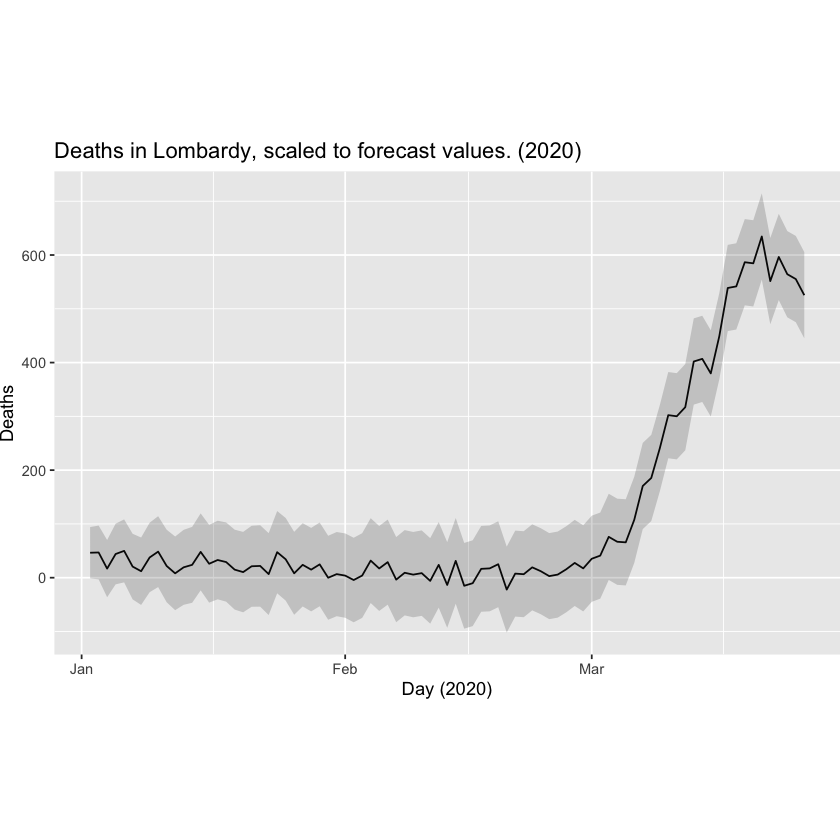

In [34]:
ggplot(Lombardia2020, aes(DATA, COVID_DEC, ymin = COVID_DEC_LO, ymax = COVID_DEC_HI)) +
geom_line() + geom_ribbon(aes(ymin=COVID_DEC_LO, ymax=COVID_DEC_HI), alpha=0.2) + 
labs(title="Deaths in Lombardy, scaled to forecast values. (2020)", y='Deaths', x='Day (2020)') + 
theme(plot.margin = margin(3,0,3,0, "cm"))  

As one can see clearly, all of the data before March 2020 is non-significant, with the given confidence interval of 90%. On the other hand, starting from March, there is a sharp incline in cases: we can infer this is due to the **covid-19** pandemic. Indeed, a sharp, quasi-exponential growth of deaths in period, is comparable to traditional epidemioogic curves. 

# Comparison with recorded covid-19 cases

In [35]:
# Read recorder covid-19 deaths
lomb <- read.csv("regione_giorno.csv") %>%
  dplyr::filter(denominazione_regione == "Lombardia") %>%
  dplyr::select(c(data, deceduti )) %>%
  arrange(data)
lomb$data = as.Date(lomb$data,format="%Y-%m-%d")

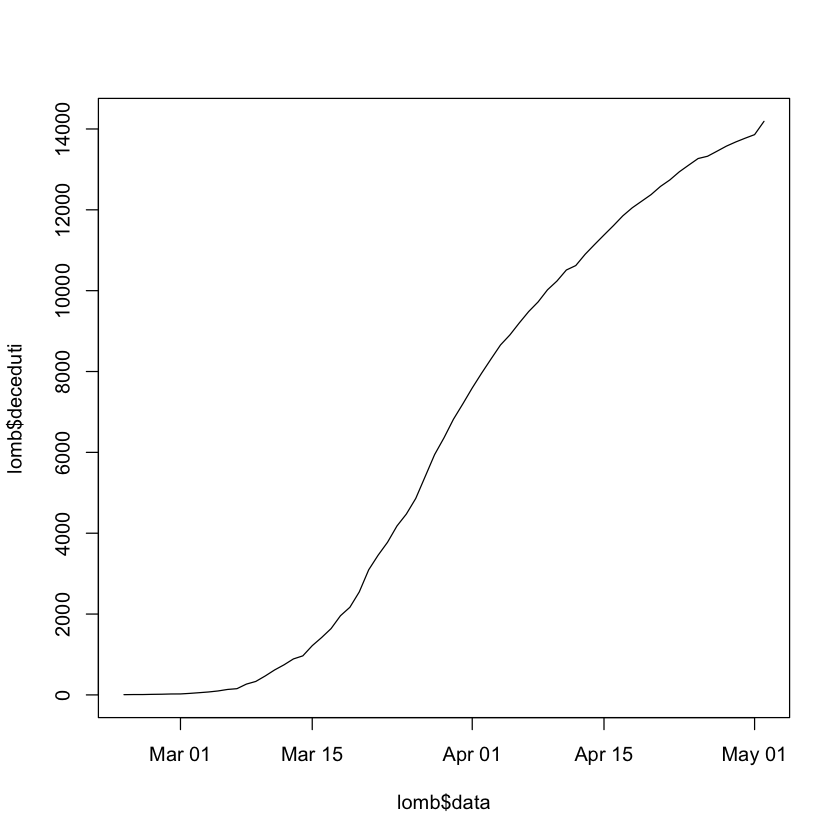

In [36]:
plot(x=lomb$data, y=lomb$deceduti, type='l')

In [37]:
# The data is cumulative, so I need to do 
# running differences
lomb["diff"] = c(6, diff(lomb$deceduti))
# Change the name to fit the schema of the analysis
names(lomb)[names(lomb) == "data"] <- "DATA"
# Merge the two dataset
final_df = merge(Lombardia2020, lomb, by="DATA")

In [38]:
pdf("images/confront.pdf")
ggplot(final_df, mapping=aes(x=DATA, ymin = COVID_DEC_LO, ymax = COVID_DEC_HI)) +
geom_line(aes(y=COVID_DEC, colour='1')) + 
geom_ribbon(aes(ymin=COVID_DEC_LO, ymax=COVID_DEC_HI), alpha=0.2) + 
geom_line(mapping=aes(y=diff, colour='2')) + 
labs(title="Comparison between estimated and reported covid-19 deaths in Lombardy", y='Deaths', x='Day (2020)') +
scale_color_discrete(name = "", labels = c("Estimated", "Reported")) + 
theme(plot.margin = margin(3,0,3,0, "cm"))  
dev.off()

pdf 
  2

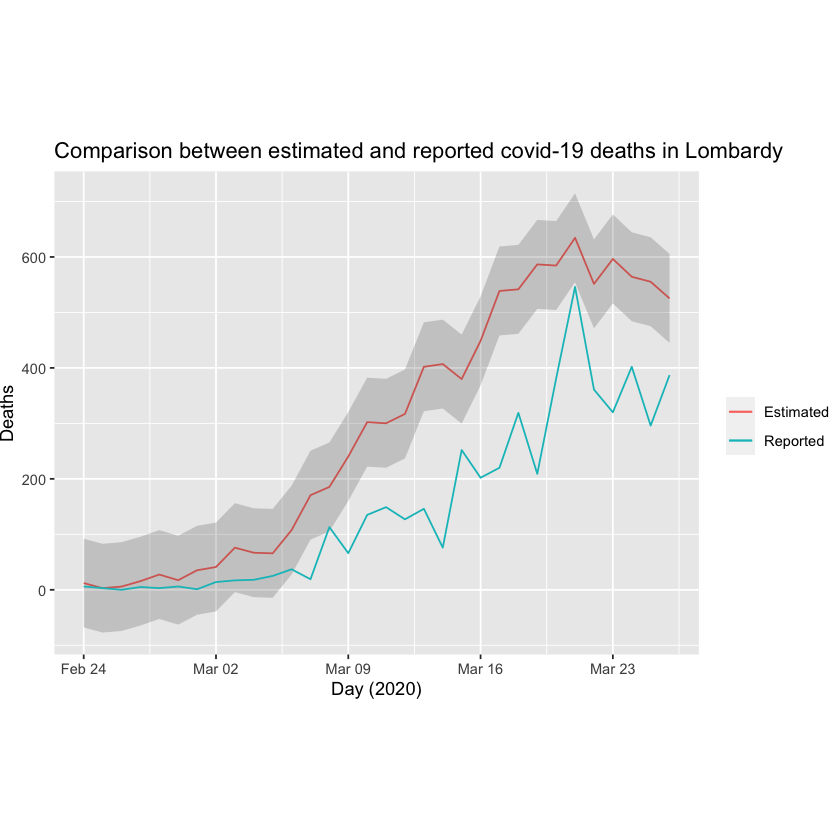

In [39]:
ggplot(final_df, mapping=aes(x=DATA, ymin = COVID_DEC_LO, ymax = COVID_DEC_HI)) +
geom_line(aes(y=COVID_DEC, colour='1')) + 
geom_ribbon(aes(ymin=COVID_DEC_LO, ymax=COVID_DEC_HI), alpha=0.2) + 
geom_line(mapping=aes(y=diff, colour='2')) + 
labs(title="Comparison between estimated and reported covid-19 deaths in Lombardy", y='Deaths', x='Day (2020)') +
scale_color_discrete(name = "", labels = c("Estimated", "Reported")) + 
theme(plot.margin = margin(3,0,3,0, "cm"))  

The results are astonishing: starting from 6th March, the difference between the estimated death count and the reported one is statistically significant. Indeed, this graph shows how many more deaths are not reported as covid-19, but most likely are. Even with these results at hand, we cannot fully declare that all of the excess deaths are due directly to the coronavirus: some may be linked indirectly. What this means is that there could a considerable portion of these deaths that are not caused by covid-19, i.e. the person who died wasn't sick, but was not able to receive care due to multiple pandemic-related reasons, e.g. overcapacity in some hospitals.

In [40]:
final_df[c('Point.Forecast', 'DECESSI', 'Lo.99', 'Hi.99', 'deceduti')] = NULL 

In [41]:
names(final_df)[names(final_df) == "COVID_DEC"] = "Estimated.Deceased"

In [42]:
names(final_df)[names(final_df) == "COVID_DEC_LO"] = "Estimated.Deceased.Lower"
names(final_df)[names(final_df) == "COVID_DEC_HI"] = "Estimated.Deceased.Higher"

In [43]:
names(final_df)[names(final_df) == "diff"] = "Reported.Deceased"

In order to calculate the cumulative values for the estimated curve, i.e. the total sum and its deviation, we had to use **uncertainty propagation**. Just by looking at the data, one can show that each daily deviation is approximately the same, of around $\pm 80$. While this might be a good clue about incorrelation between each one of these, as is the fact they come from an Arima model, we nevertheless decided to employ a more general method. Indeed, we approached the problem through the use of a dedicated library; with this, we used two comparable methods:

- Second degree Taylor approximation for the analytical formula. With this results, we did not find any difference with the incorrelated calculation, as shown by the covariance matrix calculated by the same.
- Monte Carlo numerical evalutation, which showed a very small difference with the incorrelated case. This calculation has been carried out with a large number of simulations, and thus can be considered quite accurate.

From the two previous results, one can argue that, if there is some correlation to be considered in the calculation for the cumulated error, it is but small and not distinguishable to a second degree approximation. 
    
We show below then the results obtained, and our final conclusions.    

In order to estimate the final, we use erro propagation, i.e. we do a squared sum of point deviations. In order to do this

In [44]:
# Evaluate the deviances for each point
radii = final_df$Estimated.Deceased.Higher - final_df$Estimated.Deceased
# Create a joiend dataset with the estimated values
# and their deviances
df_for_propagation = cbind(final_df["Estimated.Deceased"], radii)
# For the library we use, I have to take the transpose
df_for_propagation = t(df_for_propagation)
# We have to assign names to the columns
names_arr = array()
for (i in seq(1,ncol(df_for_propagation))){
    names_arr = c(names_arr, paste0("x",i))
}
names_arr = names_arr[-1]
colnames(df_for_propagation) = names_arr
# The library works with expression, thus 
# I have to create one
my_sum = ""
for (name in colnames(df_for_propagation)){
    if(name == "x32"){
        my_sum = paste0(my_sum, name, sep="")
    }
    else{
        my_sum = paste0(my_sum, name, sep=" + ")
    }

}
EXPR1 = parse(text=my_sum)

In [45]:
# Evaluate propagation of uncertainty with 
# 2nd-degree Taylor approximation and 
# Monte-Carlo simulation
RES1 <- propagate(expr = EXPR1, data = df_for_propagation, type = "stat", 
                  do.sim = TRUE, verbose = TRUE, cov=TRUE,
                  nsim = 1e7)

In [46]:
summary(RES1)

Results from error propagation:



    Mean.1     Mean.2       sd.1       sd.2       2.5%      97.5% 
 9305.6739  9305.6739   453.3394   453.3394  8417.1449 10194.2028 


Results from Monte Carlo simulation:



      Mean         sd     Median        MAD       2.5%      97.5% 
 9305.4589   453.2515  9305.6877   453.2228  8416.6174 10193.9911 


Welch-Satterthwaite degrees of freedom:



[1] 31999931


Coverage factor (k):



[1] 1.959964


Expanded uncertainty:



[1] 888.529


Symbolic gradient matrix:



 [1] "1" "1" "1" "1" "1" "1" "1" "1" "1" "1" "1" "1" "1" "1" "1" "1" "1" "1" "1"
[20] "1" "1" "1" "1" "1" "1" "1" "1" "1" "1" "1" "1" "1"


Evaluated gradient matrix (sensitivity):



 [1] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


Symbolic hessian matrix:



 [1] "0" "0" "0" "0" "0" "0" "0" "0" "0" "0" "0" "0" "0" "0" "0" "0" "0" "0" "0"
[20] "0" "0" "0" "0" "0" "0" "0" "0" "0" "0" "0" "0" "0"
 [1] "0" "0" "0" "0" "0" "0" "0" "0" "0" "0" "0" "0" "0" "0" "0" "0" "0" "0" "0"
[20] "0" "0" "0" "0" "0" "0" "0" "0" "0" "0" "0" "0" "0"
 [1] "0" "0" "0" "0" "0" "0" "0" "0" "0" "0" "0" "0" "0" "0" "0" "0" "0" "0" "0"
[20] "0" "0" "0" "0" "0" "0" "0" "0" "0" "0" "0" "0" "0"
 [1] "0" "0" "0" "0" "0" "0" "0" "0" "0" "0" "0" "0" "0" "0" "0" "0" "0" "0" "0"
[20] "0" "0" "0" "0" "0" "0" "0" "0" "0" "0" "0" "0" "0"
 [1] "0" "0" "0" "0" "0" "0" "0" "0" "0" "0" "0" "0" "0" "0" "0" "0" "0" "0" "0"
[20] "0" "0" "0" "0" "0" "0" "0" "0" "0" "0" "0" "0" "0"
 [1] "0" "0" "0" "0" "0" "0" "0" "0" "0" "0" "0" "0" "0" "0" "0" "0" "0" "0" "0"
[20] "0" "0" "0" "0" "0" "0" "0" "0" "0" "0" "0" "0" "0"
 [1] "0" "0" "0" "0" "0" "0" "0" "0" "0" "0" "0" "0" "0" "0" "0" "0" "0" "0" "0"
[20] "0" "0" "0" "0" "0" "0" "0" "0" "0" "0" "0" "0" "0"
 [1] "0" "0" "0" "0" "0" "0" "0" "

Evaluated hessian matrix:



 [1] 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 [1] 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 [1] 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 [1] 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 [1] 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 [1] 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 [1] 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 [1] 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 [1] 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 [1] 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 [1] 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 [1] 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 [1] 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 [1] 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 [1] 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

Covariance matrix:



          x1       x2       x3       x4       x5      x6      x7       x8
x1  6399.251    0.000    0.000    0.000    0.000    0.00    0.00    0.000
x2     0.000 6402.248    0.000    0.000    0.000    0.00    0.00    0.000
x3     0.000    0.000 6405.072    0.000    0.000    0.00    0.00    0.000
x4     0.000    0.000    0.000 6407.576    0.000    0.00    0.00    0.000
x5     0.000    0.000    0.000    0.000 6409.929    0.00    0.00    0.000
x6     0.000    0.000    0.000    0.000    0.000 6412.02    0.00    0.000
x7     0.000    0.000    0.000    0.000    0.000    0.00 6413.98    0.000
x8     0.000    0.000    0.000    0.000    0.000    0.00    0.00 6415.727
x9     0.000    0.000    0.000    0.000    0.000    0.00    0.00    0.000
x10    0.000    0.000    0.000    0.000    0.000    0.00    0.00    0.000
x11    0.000    0.000    0.000    0.000    0.000    0.00    0.00    0.000
x12    0.000    0.000    0.000    0.000    0.000    0.00    0.00    0.000
x13    0.000    0.000    0.000    0.00

Relative contribution:



            x1         x2         x3         x4         x5         x6
x1  0.03113739 0.00000000 0.00000000 0.00000000 0.00000000 0.00000000
x2  0.00000000 0.03115197 0.00000000 0.00000000 0.00000000 0.00000000
x3  0.00000000 0.00000000 0.03116571 0.00000000 0.00000000 0.00000000
x4  0.00000000 0.00000000 0.00000000 0.03117789 0.00000000 0.00000000
x5  0.00000000 0.00000000 0.00000000 0.00000000 0.03118934 0.00000000
x6  0.00000000 0.00000000 0.00000000 0.00000000 0.00000000 0.03119952
x7  0.00000000 0.00000000 0.00000000 0.00000000 0.00000000 0.00000000
x8  0.00000000 0.00000000 0.00000000 0.00000000 0.00000000 0.00000000
x9  0.00000000 0.00000000 0.00000000 0.00000000 0.00000000 0.00000000
x10 0.00000000 0.00000000 0.00000000 0.00000000 0.00000000 0.00000000
x11 0.00000000 0.00000000 0.00000000 0.00000000 0.00000000 0.00000000
x12 0.00000000 0.00000000 0.00000000 0.00000000 0.00000000 0.00000000
x13 0.00000000 0.00000000 0.00000000 0.00000000 0.00000000 0.00000000
x14 0.00000000 0.000

Skewness / Excess Kurtosis of MC evaluations:



-0.0009923809 / -0.002097055 


Shapiro-Wilk test for normality: 



0.2050796 => normal


Kolmogorov-Smirnov test for normality: 



0.4039188 => normal


In [47]:
# I report here the final results.
# They have been written by hand for laziness
paste("For the period between", final_df[1,]$DATA, " and", final_df[nrow(final_df),]$DATA,
     "we estimated the number of deceased due to covid-19.")  %>% cat()
paste("\nWe found that the total number of deaths is between", 9305 - 453, "and ", 9305 + 453, ".
        This results have been estimated with a 99% confidence interval.") %>% cat()
paste("\nBy comparison, the total number of reported cases in the same time period is:", sum(final_df$Reported.Deceased)) %>% 
cat()
paste(".\nThere is a ",as.integer((9305 - 453)/sum(final_df$Reported.Deceased)*100),"% to ", as.integer((9305 + 453)/sum(final_df$Reported.Deceased)*100), 
"% increase of covid-19 related deaths, according to our calculations.") %>% cat()

For the period between 2020-02-24  and 2020-03-26 we estimated the number of deceased due to covid-19.
We found that the total number of deaths is between 8852 and  9758 .
        This results have been estimated with a 99% confidence interval.
By comparison, the total number of reported cases in the same time period is: 4861.
There is a  182 % to  200 % increase of covid-19 related deaths, according to our calculations.